### Exploring Clustering with Online Retail data from UCI
MSDS 7331 Data Mining Lab 3

Authors: Laura Ludwig, Anthony Schams, Josh Balson, David Stroud

This is a trans-national data set which contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail.The company mainly sells unique all-occasion gifts. Many customers of the company are wholesalers.

The selection of attributes plays an important role in good clustering analysis. Therefore, we will cluster the RPM (Recency, Frequency, Monetary) variables using the Online Retail Data Set from the UCI Machine Learning Repository.

RPM analysis has historically been used to analyze large retail data sets of customer purchases to analyze retailer business activity. To accomplish this task, we will use clustering techniques to identify segments in the purchasing patterns to identify common characteristics. Since our data set is primarily composed of retailers purchasing from a wholesaler, it is in our best interest to identify the retailers purchasing patterns.

Market segmentation allows a business to analyze, understand and draw good market segements from the customers purchasing behavior. Clustering analysis will allow us to identify segments of retail purchases who have certain characteristics. Idenfication of these paterns give us an information advantage, thus allowing us to act on better solutions for our clients.

Once the data set has been properly cleaned, clustering intends to identify whether customers can be segmented meaningfully in the view of recency, frequency and monetary values. The k-means clustering algorithm was employed specifically for this purpose.

### Attribute Information:
 - InvoiceNo: Invoice number. Nominal, a 6-digit integral number uniquely assigned to each transaction. If this code starts with letter 'c', it indicates a cancellation.
 - StockCode: Product (item) code. Nominal, a 5-digit integral number uniquely assigned to each distinct product.
 - Description: Product (item) name. Nominal.
 - Quantity: The quantities of each product (item) per transaction. Numeric.
 - InvoiceDate: Invice Date and time. Numeric, the day and time when each transaction was generated.
UnitPrice: Unit price. Numeric, Product price per unit in sterling.
 - CustomerID: Customer number. Nominal, a 5-digit integral number uniquely assigned to each customer.
 - Country: Country name. Nominal, the name of the country where each customer res

In [53]:
import pandas as pd
import numpy as np

import time, warnings
import datetime as dt

#modules for predictive models
import sklearn.cluster as cluster
from sklearn.cluster import KMeans, SpectralClustering, AgglomerativeClustering, DBSCAN
from sklearn.decomposition import PCA
from sklearn.mixture import GMM
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_samples, silhouette_score, calinski_harabaz_score

#visualizations
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
%matplotlib inline
import seaborn as sns
import matplotlib.patches as mpatches
from mpl_toolkits.mplot3d import Axes3D

warnings.filterwarnings("ignore")

In [2]:
#df = pd.read_excel('OnlineRetail.xlsx')
df = pd.read_csv('OnlineRetail.csv')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/10 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/10 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/10 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/10 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/10 8:26,3.39,17850.0,United Kingdom


In [3]:
# Note that we have more than 540,000 instances
# and eight variables with the original dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
InvoiceNo      541909 non-null object
StockCode      541909 non-null object
Description    540455 non-null object
Quantity       541909 non-null int64
InvoiceDate    541909 non-null object
UnitPrice      541909 non-null float64
CustomerID     406829 non-null float64
Country        541909 non-null object
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [4]:
# Remove all of the cancelled orders
# df = df.loc[(~df['InvoiceNo'].str.startswith('C'))] 
# Commenting out because do do this differently later in the Missing Data section

In [5]:
# We go from approximately 541,000 orders to 
# 532,000 orders, when we account for
# cancellations
# df.info()

RFM Score Calculations:
 - RECENCY (R): Days since last purchase
 - FREQUENCY (F): Total number of purchases
 - MONETARY VALUE (M): Total money this customer spent  
 
The purpose of uing the RFM analysis is to reduce the data set into attributes that may explain the business activities of the retailers.

In [6]:
# Note that we have 38 unique countries in date set# 
df.Country.nunique()

38

In [7]:
# Breakdown of each unique country
df.Country.unique()

array(['United Kingdom', 'France', 'Australia', 'Netherlands', 'Germany',
       'Norway', 'EIRE', 'Switzerland', 'Spain', 'Poland', 'Portugal',
       'Italy', 'Belgium', 'Lithuania', 'Japan', 'Iceland',
       'Channel Islands', 'Denmark', 'Cyprus', 'Sweden', 'Austria',
       'Israel', 'Finland', 'Bahrain', 'Greece', 'Hong Kong', 'Singapore',
       'Lebanon', 'United Arab Emirates', 'Saudi Arabia',
       'Czech Republic', 'Canada', 'Unspecified', 'Brazil', 'USA',
       'European Community', 'Malta', 'RSA'], dtype=object)

In [8]:
# We have a total of 4,339 customer id's ~ 3,921 are from the United Kingdom
df.CustomerID.nunique()

4372

In [9]:
# List of Countries, by CustomerID in ascending order# List o 
customer_country=df[['Country','CustomerID']].drop_duplicates()
customer_country.groupby(['Country'])['CustomerID'].aggregate('count').reset_index().sort_values('CustomerID', ascending=False)

,Country,CustomerID
36,United Kingdom,3950
14,Germany,95
13,France,87
31,Spain,31
3,Belgium,25
33,Switzerland,21
27,Portugal,19
19,Italy,15
12,Finland,12
1,Austria,11


More than 90% of the customers are from the United Kingdom

In [10]:
# Restrict data set to the United Kingdom only# 
df = df.loc[df['Country'] == 'United Kingdom']

### Missing Data
Notice that 133,277 values are missing from CustomerID. Since the analysis is based on customers, we will remove those with missing values. Thus, we are eliminating approximately twenty-five percent of the data set.

We are now down to 408,632 of the original 541,909 values

In [11]:
# Check whether there are missing values in each column
df.isnull().sum(axis=0)

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     133600
Country             0
dtype: int64

In [12]:
df = df[pd.notnull(df['CustomerID'])]

In [13]:
df.Quantity.min()

-80995

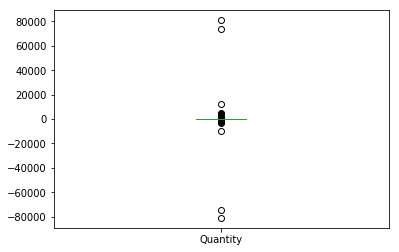

In [14]:
df.Quantity.plot(kind='box')

In [15]:
df.loc[df['Quantity'].apply(pd.to_numeric, errors='coerce').abs()>60000]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,1/18/11 10:01,1.04,12346.0,United Kingdom
61624,C541433,23166,MEDIUM CERAMIC TOP STORAGE JAR,-74215,1/18/11 10:17,1.04,12346.0,United Kingdom
540421,581483,23843,"PAPER CRAFT , LITTLE BIRDIE",80995,12/9/11 9:15,2.08,16446.0,United Kingdom
540422,C581484,23843,"PAPER CRAFT , LITTLE BIRDIE",-80995,12/9/11 9:27,2.08,16446.0,United Kingdom


In [16]:
# Create two dataframes that represent the positive transactions and negative (cancellation) transactions separately so we can combine them# Create 
df_pos = df.loc[df['Quantity']>0]
df_neg = df.loc[df['Quantity']<0]
df_neg.loc[:, 'Quantity'] = df_neg['Quantity'] * -1

# This takes all of the transactions that are positive, and matches them with any negative transactions in a new set of columns.
df_t = df_pos.merge(df_neg, how = 'left', on=['StockCode','Quantity','CustomerID'])

In [17]:
# This takes just the rows where there is a transaction and no corresponding cancellation (as best as we can find)
df_t1 = df_t.loc[df_t['InvoiceNo_y'].isnull()]
df_t2 = df_t1.iloc[:,0:8]
df_t2.columns = df.columns
df_t2.describe()

,Quantity,UnitPrice,CustomerID
count,349809.000000,349809.000000,349809.000000
mean,11.455074,2.879932,15550.102433
std,45.575768,8.295879,1594.121433
min,1.000000,0.000000,12747.000000
25%,2.000000,1.250000,14194.000000
50%,4.000000,1.850000,15524.000000
75%,12.000000,3.750000,16931.000000
max,12540.000000,2033.100000,18287.000000


In [18]:
# There are no more negative quantities, and we have the resulting shape. 
df = df_t2
df.shape

(349809, 8)

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 349809 entries, 0 to 354722
Data columns (total 8 columns):
InvoiceNo      349809 non-null object
StockCode      349809 non-null object
Description    349809 non-null object
Quantity       349809 non-null int64
InvoiceDate    349809 non-null object
UnitPrice      349809 non-null float64
CustomerID     349809 non-null float64
Country        349809 non-null object
dtypes: float64(2), int64(1), object(5)
memory usage: 24.0+ MB


The remaining dataset, having removed the orders that were cancelled and the cancelations, have 349,809 order line entries with eight different variables.

In [20]:
# Check the unique values for each column
def unique_counts(df):
    for i in df.columns:
        count = df[i].nunique()
        print(i, ":", count)
unique_counts(df)

InvoiceNo : 16424
StockCode : 3639
Description : 3835
Quantity : 282
InvoiceDate : 15412
UnitPrice : 387
CustomerID : 3910
Country : 1


In [21]:
# add a column for total price
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

In [22]:
# We now have a clean data set and are ready to 
# proceed with placing the data in RPM format
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 349809 entries, 0 to 354722
Data columns (total 9 columns):
InvoiceNo      349809 non-null object
StockCode      349809 non-null object
Description    349809 non-null object
Quantity       349809 non-null int64
InvoiceDate    349809 non-null object
UnitPrice      349809 non-null float64
CustomerID     349809 non-null float64
Country        349809 non-null object
TotalPrice     349809 non-null float64
dtypes: float64(3), int64(1), object(5)
memory usage: 26.7+ MB


## Feature Engineering

When you use domain knowledge to choose which data metrics to use as input features into a machine learning algorithm, you are using feature engineering. Feature engineering plays a key role in k-means clustering by capturing the variability of the data that is essential for the algorithm to find all of the natural-occurring groups. 


### Structure data set according to RFM analysis

In [23]:
# Find the first and last order dates in the data# Find t 
# to satisfy the Frequency requirements
df['InvoiceDate'].min() # min date

'1/10/11 10:32'

In [24]:
df['InvoiceDate'].max() # max date

'9/9/11 9:52'

In [25]:
# In order to create the frequency table, a point in time
# must be calculated. Since the last invoice date is 2011-12-09
# we will use 2011-12-10 to calculate Recency
import datetime as dt
NOW = dt.datetime(2011,12,10)

df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

In [26]:
# Create RFM table
rfmTable = df.groupby('CustomerID').agg({'InvoiceDate': lambda x:
                                        (NOW - x.max()).days,
                                        'InvoiceNo': lambda x: x.nunique(),
                                        'TotalPrice': lambda x: x.sum()})
rfmTable['AverageOrderSize']= rfmTable['TotalPrice']/rfmTable['InvoiceNo']

rfmTable['InvoiceDate'] = rfmTable['InvoiceDate'].astype(int)
rfmTable.rename(columns={'InvoiceDate': 'recency',
                        'InvoiceNo': 'frequency',
                        'TotalPrice': 'monetary_value',
                        'AverageOrderSize': 'average_order'},
               inplace=True)

In [27]:
rfmTable.head()

,recency,frequency,monetary_value,average_order
CustomerID,,,,
12747.0,2,11,4196.01,381.455455
12748.0,0,202,30559.46,151.284455
12749.0,3,5,4090.88,818.176000
12820.0,3,4,942.34,235.585000
12821.0,214,1,92.72,92.720000


#### Translation:
Customer 12747.0 has a Frequency:11, Monetary value of $4,196.01 and Recency of 2 days. This customer has made several purchases and their last purchase was two days before the end of the period of interest. 

Customer 12821.0 has a Frequency 1 , Monetary value of $92.72 and Recency of 214 days. The customer has made only one transaction, and it was 214 days ago.

In [28]:
# Sample viewing of a customer
#sample_customer = rfmTable[rfmTable['recency']==214]
#sample_customer

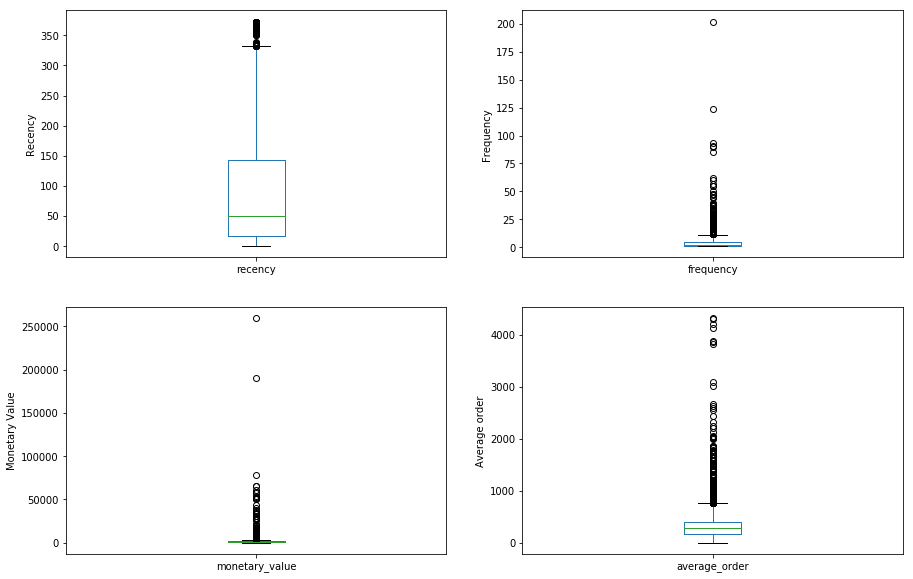

In [29]:
# Look at box plots of variables
plt.figure(figsize = (15,10))
plt.subplot(221)
rfmTable.recency.plot(kind='box')
plt.ylabel('Recency')
plt.subplot(222)
rfmTable.frequency.plot(kind='box')
plt.ylabel('Frequency')
plt.subplot(223)
rfmTable.monetary_value.plot(kind='box')
plt.ylabel('Monetary Value')
plt.subplot(224)
rfmTable.average_order.plot(kind='box')
plt.ylabel('Average order')


plt.show()

In [30]:
# get the 80% of the monetary value
pareto_cutoff = rfmTable['monetary_value'].sum() * 0.8
print("The 80% of total revenue is: ",round(pareto_cutoff,2))

The 80% of total revenue is:  5430510.04


### Create a customers rank table that ranks customers by how much they purchased¶

In [31]:
customers_rank  = rfmTable
# Create a new column that is the rank of the value of coverage in ascending order
customers_rank['Rank'] = customers_rank['monetary_value'].rank(ascending=0)
#customers_rank.drop('RevenueRank',axis=1,inplace=True)
customers_rank.head()

,recency,frequency,monetary_value,average_order,Rank
CustomerID,,,,,
12747.0,2,11,4196.01,381.455455,272.0
12748.0,0,202,30559.46,151.284455,22.0
12749.0,3,5,4090.88,818.176000,285.0
12820.0,3,4,942.34,235.585000,1489.0
12821.0,214,1,92.72,92.720000,3781.0


### Top Customers
 - Note, there is a total of 3,910 Customer ID's

In [32]:
customers_rank.sort_values('Rank',ascending=True)

,recency,frequency,monetary_value,average_order,Rank
CustomerID,,,,,
18102.0,0,60,259657.30,4327.621667,1.0
17450.0,8,45,189767.53,4217.056222,2.0
17511.0,2,30,77682.38,2589.412667,3.0
16684.0,4,27,65767.48,2435.832593,4.0
14096.0,4,17,65164.79,3833.222941,5.0
13694.0,3,48,61403.14,1279.232083,6.0
15311.0,0,90,58949.31,654.992333,7.0
13089.0,2,93,57573.28,619.067527,8.0
15061.0,3,48,54391.94,1133.165417,9.0


In [33]:
# get the top 20% of customers
top_20percent = 3910 * 20 / 100
top_20percent

782.0

In [34]:
# sum the monetary values over the customer with rank <=782

In [35]:
top_20percent_revenue = customers_rank[customers_rank['Rank'] <= 782]['monetary_value'].sum()
top_20percent_revenue

4873025.921

Pareto principle is basically applicable to this data set

 - The 80% of total revenue is 5430510.04 
 - Top 20% of 4873025.92

### RFM Quartiles
We will create customer segments from the RFM model and assign a score from 1 to 4.

In [36]:
quantiles = rfmTable.quantile(q=[0.25,0.5,0.75])
quantiles

,recency,frequency,monetary_value,average_order,Rank
0.25,17.0,1.0,296.2625,172.908125,978.25
0.50,50.0,2.0,639.4550,278.971111,1955.50
0.75,143.0,5.0,1538.1225,407.323125,2932.75


In [37]:
# Convert the dataframe to a dictionary for 
# building the RFM segmentation table
quantiles.to_dict()

{'recency': {0.25: 17.0, 0.5: 50.0, 0.75: 143.0},
 'frequency': {0.25: 1.0, 0.5: 2.0, 0.75: 5.0},
 'monetary_value': {0.25: 296.2625, 0.5: 639.455, 0.75: 1538.1224999999997},
 'average_order': {0.25: 172.908125,
  0.5: 278.9711111111111,
  0.75: 407.32312500000006},
 'Rank': {0.25: 978.25, 0.5: 1955.5, 0.75: 2932.75}}

### Create RFM segmentation table
Two segmentation classes are created

In [38]:
# x = value, p = recency, monetary_value, frequency, d = quartiles dict
def RScore(x,p,d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.5]:
        return 3
    elif x <= d[p][0.75]:
        return 2
    else:
        return 1

In [39]:
# x = value, p = recency, monetary_value, frequency, d = quartiles dict
def FMScore(x,p,d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.5]:
        return 3
    elif x <= d[p][0.75]:
        return 2
    else:
        return 1

In [40]:
# create RFM segmentation table
rfm_segmentation = rfmTable
rfm_segmentation['R_Quartile'] = rfm_segmentation['recency'].apply(RScore, args=('recency', quantiles,))
rfm_segmentation['F_Quartile'] = rfm_segmentation['frequency'].apply(FMScore, args=('frequency', quantiles,))
rfm_segmentation['M_Quartile'] = rfm_segmentation['monetary_value'].apply(FMScore, args=('monetary_value', quantiles,))

In [41]:
# From our code above, we have transformed the recency, frequency and montetary_value
# into four distinct quartiles 1 to 4 respectively representing 0 to 100%
rfm_segmentation.head()

,recency,frequency,monetary_value,average_order,Rank,R_Quartile,F_Quartile,M_Quartile
CustomerID,,,,,,,,
12747.0,2,11,4196.01,381.455455,272.0,4,1,1
12748.0,0,202,30559.46,151.284455,22.0,4,1,1
12749.0,3,5,4090.88,818.176000,285.0,4,2,1
12820.0,3,4,942.34,235.585000,1489.0,4,2,2
12821.0,214,1,92.72,92.720000,3781.0,1,4,4


In [42]:
rfm_segmentation['RFMScore'] = rfm_segmentation.R_Quartile.map(str) \
                            + rfm_segmentation.F_Quartile.map(str) \
                            + rfm_segmentation.M_Quartile.map(str)
rfm_segmentation.head()

,recency,frequency,monetary_value,average_order,Rank,R_Quartile,F_Quartile,M_Quartile,RFMScore
CustomerID,,,,,,,,,
12747.0,2,11,4196.01,381.455455,272.0,4,1,1,411
12748.0,0,202,30559.46,151.284455,22.0,4,1,1,411
12749.0,3,5,4090.88,818.176000,285.0,4,2,1,421
12820.0,3,4,942.34,235.585000,1489.0,4,2,2,422
12821.0,214,1,92.72,92.720000,3781.0,1,4,4,144


In [43]:
rfm_segmentation[rfm_segmentation['RFMScore']=='444'].sort_values('monetary_value', ascending=False).head(10)

,recency,frequency,monetary_value,average_order,Rank,R_Quartile,F_Quartile,M_Quartile,RFMScore
CustomerID,,,,,,,,,
17247.0,15,1,282.19,282.19,2981.0,4,4,4,444
14480.0,11,1,279.05,279.05,2993.0,4,4,4,444
17767.0,15,1,271.20,271.20,3013.0,4,4,4,444
17385.0,14,1,261.11,261.11,3046.0,4,4,4,444
16024.0,12,1,251.24,251.24,3082.0,4,4,4,444
15097.0,4,1,248.08,248.08,3097.0,4,4,4,444
13349.0,10,1,247.32,247.32,3100.0,4,4,4,444
15783.0,10,1,246.30,246.30,3103.0,4,4,4,444
16528.0,3,1,244.41,244.41,3110.0,4,4,4,444


In [44]:
print("Best Customers: ",len(rfm_segmentation[rfm_segmentation['RFMScore']=='444']))
print('Loyal Customers: ',len(rfm_segmentation[rfm_segmentation['F_Quartile']==4]))
print("Big Spenders: ",len(rfm_segmentation[rfm_segmentation['M_Quartile']==4]))
print('Almost Lost: ', len(rfm_segmentation[rfm_segmentation['RFMScore']=='244']))
print('Lost Customers: ',len(rfm_segmentation[rfm_segmentation['RFMScore']=='144']))
print('Lost Cheap Customers: ',len(rfm_segmentation[rfm_segmentation['RFMScore']=='111']))

Best Customers:  55
Loyal Customers:  1353
Big Spenders:  978
Almost Lost:  184
Lost Customers:  400
Lost Cheap Customers:  12


In [45]:
rfm_data = rfmTable
rfm_data.describe()

,recency,frequency,monetary_value,average_order,Rank,R_Quartile,F_Quartile,M_Quartile
count,3910.000000,3910.000000,3910.000000,3910.000000,3910.000000,3910.000000,3910.000000,3910.000000
mean,92.046547,4.200512,1736.096561,343.800542,1955.500000,2.508696,2.684399,2.500000
std,99.803816,7.064531,6601.251333,317.679319,1128.864101,1.123621,1.142960,1.118406
min,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000
25%,17.000000,1.000000,296.262500,172.908125,978.250000,2.000000,2.000000,1.250000
50%,50.000000,2.000000,639.455000,278.971111,1955.500000,3.000000,3.000000,2.500000
75%,143.000000,5.000000,1538.122500,407.323125,2932.750000,4.000000,4.000000,3.750000
max,373.000000,202.000000,259657.300000,4327.621667,3910.000000,4.000000,4.000000,4.000000


In [46]:
#log transformation
rfm_r_log = np.log(rfm_data['recency']+1) #can't take log(0) and so add 1 to avoid negative values
rfm_f_log = np.log(rfm_data['frequency'])
rfm_m_log = np.log(rfm_data['monetary_value']+1)
rfm_a_log = np.log(rfm_data['average_order']+1)

In [47]:
log_data = pd.DataFrame({'Monetary': rfm_m_log,'Recency': rfm_r_log,'Frequency': rfm_f_log,'AverageOrder': rfm_a_log})

In [48]:
log_data.describe()

,AverageOrder,Frequency,Monetary,Recency
count,3910.000000,3910.000000,3910.000000,3910.000000
mean,5.590189,0.938794,6.526994,3.801249
std,0.709402,0.896210,1.236157,1.383083
min,0.000000,0.000000,0.000000,0.000000
25%,5.158527,0.000000,5.694616,2.890372
50%,5.634686,0.693147,6.462179,3.931826
75%,6.012059,1.609438,7.338968,4.969813
max,8.373004,5.308268,12.467122,5.924256


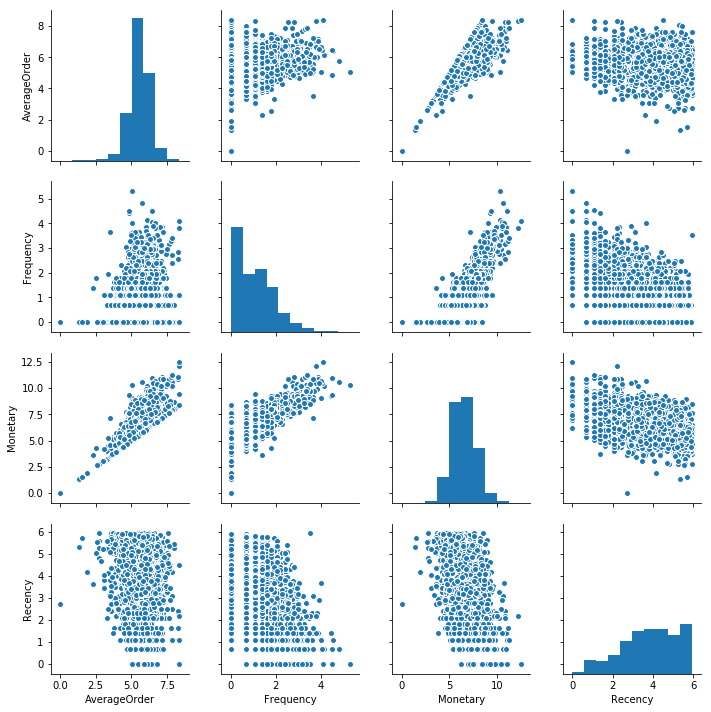

In [49]:
import seaborn as sns

sns.pairplot(log_data)

In [50]:
corr = log_data.corr()
corr.style.background_gradient()

,AverageOrder,Frequency,Monetary,Recency
AverageOrder,1,0.174811,0.701491,-0.140014
Frequency,0.174811,1,0.824331,-0.576748
Monetary,0.701491,0.824331,1,-0.498009
Recency,-0.140014,-0.576748,-0.498009,1


### Ready to begin cluster analysis

In [51]:
as_data= log_data[['Frequency','Recency','Monetary']].values
as_rfm = rfm_data[['frequency', 'recency', 'monetary_value']].values

anthony_data = np.vstack((as_data[:,0],
               as_rfm[:, 1],
               as_data[:,2])).T
ss = StandardScaler()
anthony_data = ss.fit_transform(anthony_data)


### DBSCAN

For minpts = 8 eps = 0.5 ; Silhouette_score: 0.3477467131270432 Calinski-Harabaz Score: 1226.0
For minpts = 8 eps = 0.55 ; Silhouette_score: 0.35351151917691337 Calinski-Harabaz Score: 1231.0
For minpts = 8 eps = 0.6 ; Silhouette_score: 0.3514007702376851 Calinski-Harabaz Score: 1240.0
For minpts = 8 eps = 0.65 ; Silhouette_score: 0.3563422043915 Calinski-Harabaz Score: 1233.0
For minpts = 8 eps = 0.7 ; Silhouette_score: 0.3557060723283559 Calinski-Harabaz Score: 1246.0
For minpts = 8 eps = 0.75 ; Silhouette_score: 0.3565649417421008 Calinski-Harabaz Score: 1245.0
For minpts = 9 eps = 0.5 ; Silhouette_score: 0.3473264710148699 Calinski-Harabaz Score: 1225.0
For minpts = 9 eps = 0.55 ; Silhouette_score: 0.35200448872014023 Calinski-Harabaz Score: 1229.0
For minpts = 9 eps = 0.6 ; Silhouette_score: 0.3529654179364104 Calinski-Harabaz Score: 1224.0
For minpts = 9 eps = 0.65 ; Silhouette_score: 0.3563422043915 Calinski-Harabaz Score: 1233.0
For minpts = 9 eps = 0.7 ; Silhouette_score: 0.35

Text(0.5,1,'Silhouette Score ')

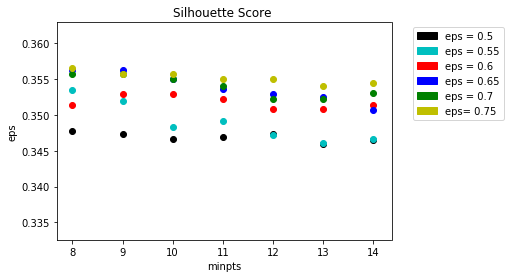

In [54]:
c = ['k','c','r','b','g','y']
for minpts in range(8,15):
    for eps in range(10,16):
        true_eps = eps/20
        clustering = DBSCAN(eps=true_eps, min_samples=minpts)
        clustering.fit(anthony_data)
        clusters = clustering.labels_
        silhouette_avg = silhouette_score(anthony_data, clusters)
        print("For minpts =", minpts,
              'eps =',true_eps,
              "; Silhouette_score:", silhouette_avg,
              'Calinski-Harabaz Score:', np.round(calinski_harabaz_score(anthony_data, clusters)))
        plt.scatter(minpts,silhouette_avg, c=c[eps-10])
red_patch = mpatches.Patch(color='red', 
                           label='eps = 0.6')
cyan_patch = mpatches.Patch(color = 'c', label = 'eps = 0.55')
blue_patch = mpatches.Patch(color='blue',
                            label = 'eps = 0.65')
black_patch = mpatches.Patch(color='black', 
                             label = 'eps = 0.5')
green_patch = mpatches.Patch(color='g',
                            label = 'eps = 0.7')
yellow_patch = mpatches.Patch(color = 'y', 
                             label = 'eps= 0.75')
plt.legend(handles=[black_patch, cyan_patch, red_patch, blue_patch, green_patch, yellow_patch],
           bbox_to_anchor=(1.05, 1),
           loc=2)

plt.xlabel('minpts')
plt.ylabel('eps')
plt.title('Silhouette Score ')

The best clustering, according to silhouette score, is for eps = 0.65 and minpts = 9. This gave a silhouette score of 0.3563. The Calinski-Harabaz scores did not very greatly amoung any of the eps-minpts pairs.

Text(0,0.5,'log(Monetary Value)')

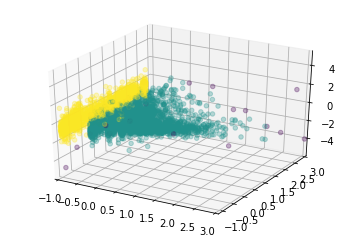

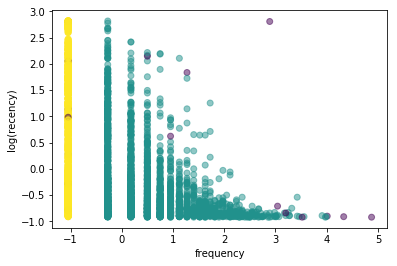

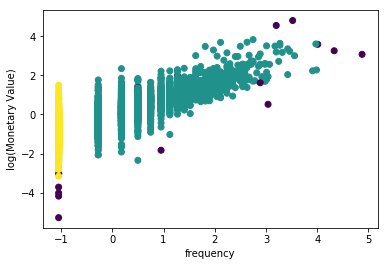

In [95]:
from mpl_toolkits.mplot3d import Axes3D


clustering = DBSCAN(eps=0.65, min_samples=9)
clustering.fit(anthony_data)
clusters = clustering.labels_

fig = plt.figure()
ax = fig.add_subplot(111,projection = '3d')
p = ax.scatter(anthony_data[:,0],
               anthony_data[:, 1],
               anthony_data[:,2],
              alpha = 0.3,
              c=clusters)

ax.set_xlim3d(-1,3)
#ax.set_ylim3d(1,6)
#ax.set_zlim3d(4,9)

plt.figure()
n_clusters_ = len(set(clusters)) - (1 if -1 in clusters else 0)
plt.scatter(anthony_data[:,0],
            anthony_data[:, 1],
            c = clusters,
           alpha = 0.5)
plt.ylabel('log(recency)')
plt.xlabel('frequency')

plt.figure()
plt.scatter(anthony_data[:,0],
            anthony_data[:, 2],
            c = clusters)
plt.xlabel('frequency')
plt.ylabel('log(Monetary Value)')

DBScan seems to create 3 clusters based heavily on frequency of purchase. One cluster seems to only have a few points in it, and they do not appear strongly correlated with one another. As can be seen in the 3-D plot however, all of these points lay distinctly outside of the other clusters. These are our noise points.

### Agglomerative Clustering

In [58]:
for n_clust in range(2,10):
    for link in ['ward', 'complete', 'average']:
        clustering2 = AgglomerativeClustering(n_clusters =n_clust, 
                                        linkage = link)
        clustering2.fit(anthony_data)
        clusters2 = clustering2.labels_
        print('n_clusters =', n_clust,
              '; linkage =', link, 
              '; Silhouette score =',silhouette_score(anthony_data, clusters2),
              '; Calinski-Harabaz score = ', np.round(calinski_harabaz_score(anthony_data, clusters2)))


n_clusters = 2 ; linkage = ward ; Silhouette score = 0.3842924414048734 ; Calinski-Harabaz score =  3063.0
n_clusters = 2 ; linkage = complete ; Silhouette score = 0.3645621247167768 ; Calinski-Harabaz score =  1941.0
n_clusters = 2 ; linkage = average ; Silhouette score = 0.6076227214160238 ; Calinski-Harabaz score =  10.0
n_clusters = 3 ; linkage = ward ; Silhouette score = 0.3894943178312267 ; Calinski-Harabaz score =  3824.0
n_clusters = 3 ; linkage = complete ; Silhouette score = 0.22779655509672886 ; Calinski-Harabaz score =  1875.0
n_clusters = 3 ; linkage = average ; Silhouette score = 0.4943072946107462 ; Calinski-Harabaz score =  8.0
n_clusters = 4 ; linkage = ward ; Silhouette score = 0.31259587404786837 ; Calinski-Harabaz score =  3411.0
n_clusters = 4 ; linkage = complete ; Silhouette score = 0.1994266228337823 ; Calinski-Harabaz score =  1335.0
n_clusters = 4 ; linkage = average ; Silhouette score = 0.35389714134028 ; Calinski-Harabaz score =  402.0
n_clusters = 5 ; linka

Agglomerative clustering yields a slightly different result from DBSCAN. The best clustering, according to silhouette score, is for n_clusters = 2 and average linkage. Let's look at this result more carefully.

Text(0,0.5,'log(Monetary Value)')

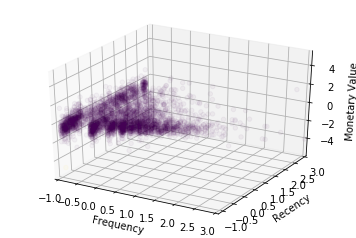

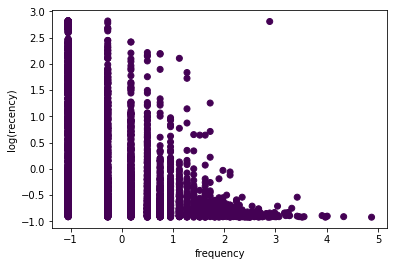

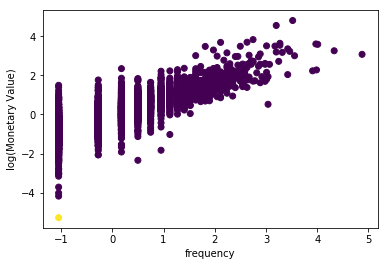

In [94]:
clustering2 = AgglomerativeClustering(n_clusters =2, 
                                linkage = 'average')
clustering2.fit(anthony_data)
clusters2 = clustering2.labels_
fig = plt.figure()
ax = fig.add_subplot(111,projection = '3d')
p = ax.scatter(anthony_data[:,0],
               anthony_data[:, 1],
               anthony_data[:,2],
              alpha = 0.04,
              c=clusters2)
ax.set_xlim3d(-1,3)
ax.set_xlabel('Frequency')
ax.set_ylabel('Recency')
ax.set_zlabel('Monetary Value')

plt.figure()
plt.scatter(anthony_data[:,0],
            anthony_data[:, 1],
            c = clusters2)
plt.ylabel('log(recency)')
plt.xlabel('frequency')

plt.figure()
plt.scatter(anthony_data[:,0],
            anthony_data[:, 2],
            c = clusters2)
plt.xlabel('frequency')
plt.ylabel('log(Monetary Value)')

Text(0,0.5,'log(monetary value)')

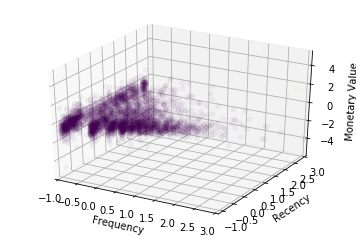

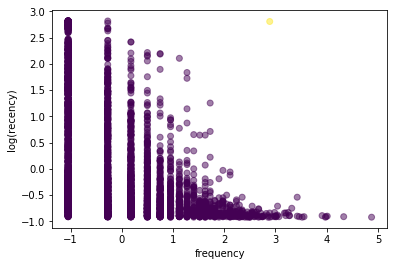

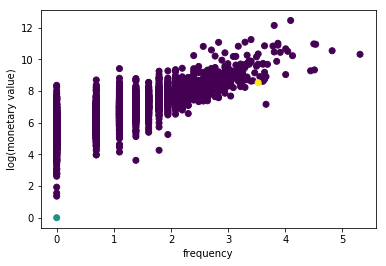

In [92]:
clustering3 = AgglomerativeClustering(n_clusters =3, 
                                linkage = 'average')
clustering3.fit(anthony_data)
clusters3 = clustering3.labels_
fig = plt.figure()
ax = fig.add_subplot(111,projection = '3d')
p = ax.scatter(anthony_data[:,0],
               anthony_data[:, 1],
               anthony_data[:,2],
              alpha = 0.04,
              c=clusters3)
ax.set_xlim3d(-1,3)
ax.set_xlabel('Frequency')
ax.set_ylabel('Recency')
ax.set_zlabel('Monetary Value')

plt.figure()
plt.scatter(anthony_data[:,0],
            anthony_data[:, 1],
            c = clusters3,
           alpha = 0.5)
plt.ylabel('log(recency)')
plt.xlabel('frequency')

plt.figure()
plt.scatter(as_data[:,0],
            as_data[:, 2],
            c = clusters3)

plt.xlabel('frequency')
plt.ylabel('log(monetary value)')

These clustering parameters yield 3 clusters. 2 of them contain 1 point each, and the third is the rest of the data. These clusters are not very meaningful except to identify these 2 outliers.

We will therefore look at the third best agglomerative clustering result, according to silhouette score: n_clusters = 3, with Ward linkage. This has the highest Calinski-Harabaz score.

Text(0,0.5,'log(Monetary Value)')

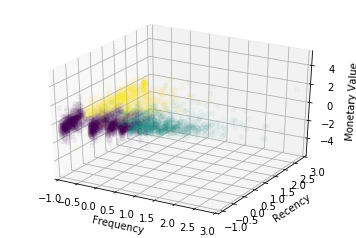

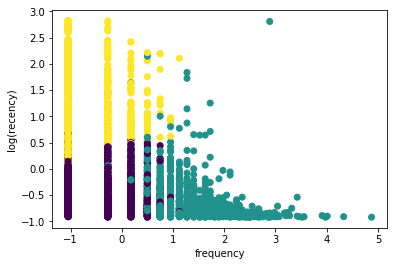

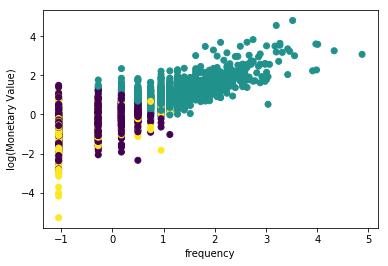

In [86]:
clustering4 = AgglomerativeClustering(n_clusters =3, 
                                linkage = 'ward')
clustering4.fit(anthony_data)
clusters4 = clustering4.labels_
fig = plt.figure()
ax = fig.add_subplot(111,projection = '3d')
p = ax.scatter(anthony_data[:,0],
               anthony_data[:, 1],
               anthony_data[:,2],
              alpha = 0.04,
              c=clusters4)
ax.set_xlabel('Frequency')
ax.set_ylabel('Recency')
ax.set_zlabel('Monetary Value')
ax.set_xlim3d(-1,3)


plt.figure()
plt.scatter(anthony_data[:,0],
            anthony_data[:, 1],
            c = clusters4)
plt.ylabel('log(recency)')
plt.xlabel('frequency')

plt.figure()
plt.scatter(anthony_data[:,0],
            anthony_data[:, 2],
            c = clusters4)
plt.xlabel('frequency')
plt.ylabel('log(Monetary Value)')

This looks like a real clustering result! 
- The first cluster (yellow) is characterized by less frequent, less recent buyers. They also typically buy less than the average buyer.
- The second cluster (purple) is less frequent spenders that recently purchased goods. They typically spend around the average amount of money.
- The third cluster (green) is buyers that have recently bought. They typically buy less frequently, but they spend more money that the average customer.

It appears that the Calinski-Harabaz score may be better at identifying practically significant clusters. Let's look at the second best Calinski-Harabaz score, n_clusters = 4 with Ward linkage.

Text(0,0.5,'log(Monetary Value)')

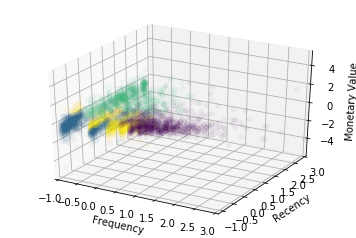

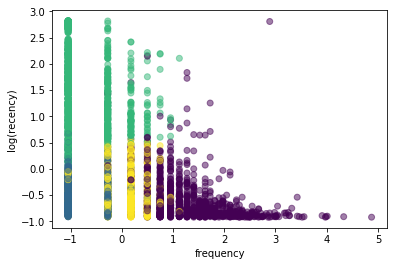

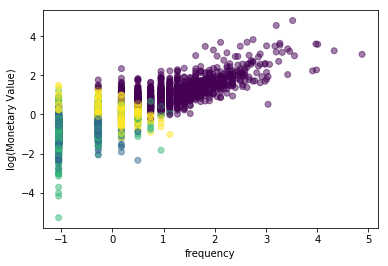

In [87]:
clustering5 = AgglomerativeClustering(n_clusters =4, 
                                linkage = 'ward')
clustering5.fit(anthony_data)
clusters5 = clustering5.labels_
fig = plt.figure()
ax = fig.add_subplot(111,projection = '3d')
p = ax.scatter(anthony_data[:,0],
               anthony_data[:, 1],
               anthony_data[:,2],
              alpha = 0.04,
              c=clusters5)
ax.set_xlim3d(-1,3)
ax.set_xlabel('Frequency')
ax.set_ylabel('Recency')
ax.set_zlabel('Monetary Value')

plt.figure()
plt.scatter(anthony_data[:,0],
            anthony_data[:, 1],
            c = clusters5,
           alpha = 0.5)
plt.ylabel('log(recency)')
plt.xlabel('frequency')


plt.figure()
plt.scatter(anthony_data[:,0],
            anthony_data[:, 2],
            c = clusters5,
            alpha = 0.5)
plt.xlabel('frequency')
plt.ylabel('log(Monetary Value)')

- The purple cluster is similar to the green cluster in the previous clustering.
- (Blue) Low frequency that bought recently
- (Green) Low frequency that have not bought recently
- (Yellow) Slightly below average recency scores, average frequency scores, with average amounts spent.

### KMeans

In [71]:
for n_clust in range(2,10):
    clustering = KMeans(n_clusters =n_clust, 
                        init = 'k-means++')
    clustering.fit(anthony_data)
    clusters = clustering.labels_
    print('n_clusters =', n_clust,
          '; Silhouette score =',silhouette_score(anthony_data, clusters),
          '; Calinski-Harabaz score = ', np.round(calinski_harabaz_score(anthony_data, clusters)))

n_clusters = 2 ; Silhouette score = 0.4154553515237364 ; Calinski-Harabaz score =  3744.0
n_clusters = 3 ; Silhouette score = 0.4095887952232401 ; Calinski-Harabaz score =  4067.0
n_clusters = 4 ; Silhouette score = 0.37669299446165166 ; Calinski-Harabaz score =  4016.0
n_clusters = 5 ; Silhouette score = 0.3450597774781101 ; Calinski-Harabaz score =  3672.0
n_clusters = 6 ; Silhouette score = 0.34230295371748554 ; Calinski-Harabaz score =  3568.0
n_clusters = 7 ; Silhouette score = 0.3328819996648954 ; Calinski-Harabaz score =  3362.0
n_clusters = 8 ; Silhouette score = 0.30448346949798943 ; Calinski-Harabaz score =  3214.0
n_clusters = 9 ; Silhouette score = 0.30965547963407797 ; Calinski-Harabaz score =  3133.0


n_clusters = 2 has the highest Silhouette score, while n_clusters=3 has the highest Calinski-Harabaz score. We will examine both to see what inferences we can make.

Text(0,0.5,'log(Monetary Value)')

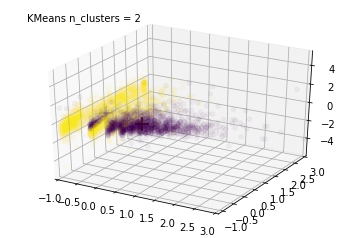

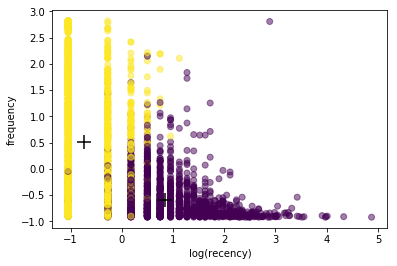

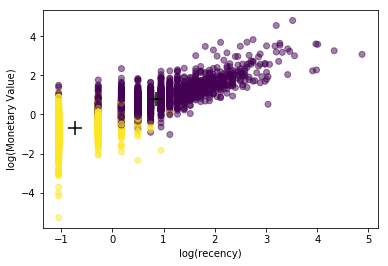

In [77]:
clustering6 = KMeans(n_clusters = 2, init = 'k-means++')
clustering6.fit(anthony_data)
clusters6 = clustering6.labels_
km_centroids = clustering6.cluster_centers_


fig = plt.figure()

ax = fig.add_subplot(111,projection = '3d')
ax.text2D(0.05, 0.95, "KMeans n_clusters = 2", transform=ax.transAxes)
p = ax.scatter(anthony_data[:,0],
               anthony_data[:, 1],
               anthony_data[:,2],
              alpha = 0.04,
              c=clusters6)

p2 = ax.scatter(km_centroids[:,0],
                km_centroids[:,1],
                km_centroids[:,2],
                c='k',
                s = 200,
                marker = '+')

ax.set_xlim3d(-1,3)
ax.set_xlabel('Frequency')
ax.set_ylabel('Recency')
ax.set_zlabel('Monetary Value')

plt.figure()

plt.scatter(anthony_data[:,0],
            anthony_data[:, 1],
            c = clusters6,
           alpha = 0.5)


plt.scatter(km_centroids[:,0],
           km_centroids[:,1],
           c='k',
           marker='+',
           s=200)

plt.ylabel('log(recency)')
plt.xlabel('frequency')

plt.figure()

plt.scatter(anthony_data[:,0],
            anthony_data[:, 2],
            c = clusters6,
            alpha = 0.5)

plt.scatter(km_centroids[:,0],
           km_centroids[:,2],
           c='k',
           marker='+',
           s=200)

plt.xlabel('frequency')
plt.ylabel('log(Monetary Value)')

Text(0,0.5,'log(Monetary Value)')

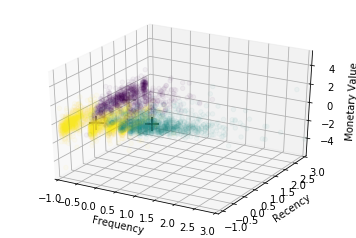

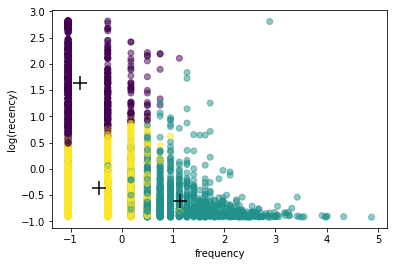

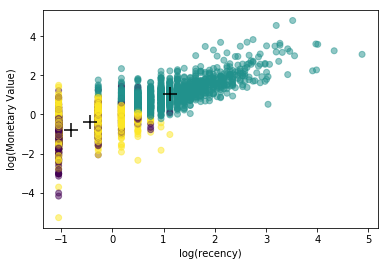

In [78]:
clustering7 = KMeans(n_clusters = 3, init = 'k-means++')
clustering7.fit(anthony_data)
clusters7 = clustering7.labels_
fig = plt.figure()
ax = fig.add_subplot(111,projection = '3d')
p = ax.scatter(anthony_data[:,0],
               anthony_data[:, 1],
               anthony_data[:,2],
              alpha = 0.04,
              c=clusters7)
ax.set_xlim3d(-1,3)
ax.set_xlabel('Frequency')
ax.set_ylabel('Recency')
ax.set_zlabel('Monetary Value')

km2_centroids = clustering7.cluster_centers_
p2 = ax.scatter(km2_centroids[:,0],
                km2_centroids[:,1],
                km2_centroids[:,2],
                c='k',
                s = 200,
                marker = '+')


plt.figure()
plt.scatter(anthony_data[:,0],
            anthony_data[:, 1],
            c = clusters7,
           alpha = 0.5)

plt.scatter(km2_centroids[:,0],
           km2_centroids[:,1],
           c='k',
           marker='+',
           s=200)

plt.ylabel('log(recency)')
plt.xlabel('frequency')

plt.figure()
plt.scatter(anthony_data[:,0],
            anthony_data[:, 2],
            c = clusters7,
            alpha = 0.5)
plt.scatter(km2_centroids[:,0],
           km2_centroids[:,2],
           c='k',
           marker='+',
           s=200)

plt.xlabel('frequency')
plt.ylabel('log(Monetary Value)')